In [19]:
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
from tgan.model import TGANModel

In [2]:
prices = pd.read_csv('data/log_prices.csv', index_col='date')
prices = prices.dropna()
prices['type'] = 'real'
prices.head()

,brn,cl,ho,xrb,type
date,,,,,
20150105,0.010676,0.025528,-0.023495,0.032481,real
20150112,-0.039646,-0.081290,-0.008362,-0.018356,real
20150119,0.082589,0.041151,0.022561,0.087349,real
20150126,0.117570,0.118920,0.091463,0.075879,real
20150202,0.056883,0.012610,0.069970,0.039044,real


Empirical correlation

In [3]:
prices.corr()

,brn,cl,ho,xrb
brn,1.000000,0.890081,0.846233,0.719229
cl,0.890081,1.000000,0.778133,0.658417
ho,0.846233,0.778133,1.000000,0.620990
xrb,0.719229,0.658417,0.620990,1.000000


## Copula Generation

Modeling of a copula. Given a random vector $(X_1, \dots, X_d)$, the copula is defined as

$$C(u_1, \dots, u_n) = \mathbb P(X_1 \leq F^{-1}_1(u_1), \dots, X_d \leq F^{-1}_d(u_d))$$

where $F^{-1}_i$ is a reverse CDF of $X_i$ RV and $u_i$ is a random realization from a uniform $U_i$ RV.

Suppose that these are t-distributions. Fit parameters of marginal distributions.

In [4]:
param = {'brn': stats.t.fit(prices.brn), 
         'cl': stats.t.fit(prices.cl), 
         'ho': stats.t.fit(prices.ho), 
         'xrb': stats.t.fit(prices.xrb)}
pd.DataFrame(param, index=['df', 'loc', 'scale']).T

,df,loc,scale
brn,4.717482,0.001396,0.036572
cl,35.155460,0.000365,0.045774
ho,5.572727,0.000280,0.033830
xrb,5.853887,-0.000273,0.040088


Generating 10000 observations from the Normal distribution

In [5]:
cov = np.array(prices.cov())
norm_sample = np.random.multivariate_normal([0, 0, 0, 0], cov, size=10000)

Uniform transformation

In [6]:
unif_sample = []
for i, i_sample in enumerate(norm_sample.T):
    unif_sample.append(stats.norm.cdf(i_sample, loc=0, scale=cov[i][i]**(1/2)))
unif_sample = np.array(unif_sample)

Student's t transformation

In [7]:
df, loc, scale = param['brn']
brn_sample = stats.t.ppf(unif_sample[0], df, loc, scale)

df, loc, scale = param['cl']
cl_sample = stats.t.ppf(unif_sample[1], df, loc, scale)

df, loc, scale = param['ho']
ho_sample = stats.t.ppf(unif_sample[2], df, loc, scale)

df, loc, scale = param['xrb']
xrb_sample = stats.t.ppf(unif_sample[3], df, loc, scale)

gen_prices = pd.DataFrame({'brn': brn_sample, 
                           'cl': cl_sample, 
                           'ho': ho_sample, 
                           'xrb': xrb_sample})
gen_prices['type'] = 'generated'

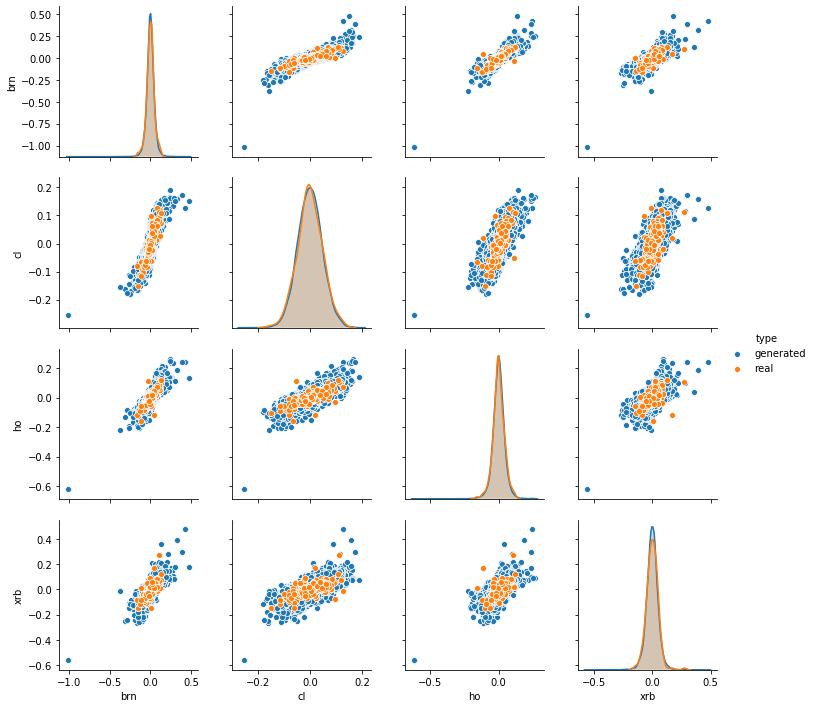

In [8]:
sb.pairplot(pd.concat([gen_prices, prices]), hue="type")
plt.show()

In [9]:
gen_prices.corr()

,brn,cl,ho,xrb
brn,1.000000,0.864288,0.838939,0.723488
cl,0.864288,1.000000,0.768065,0.659804
ho,0.838939,0.768065,1.000000,0.623405
xrb,0.723488,0.659804,0.623405,1.000000


In [10]:
print(stats.t.fit(prices.cl))
print(stats.t.fit(gen_prices.cl))

(35.15545988613356, 0.0003650380447012075, 0.045773879438890136)
(35.90154783410827, 0.00010018036995187703, 0.045904062239858906)


In [11]:
sample = stats.t.rvs(35, 0, 0.5, 200)
stats.t.fit(sample)

(2071913.4046390597, -0.06092191909197759, 0.5246008817015408)

## Empirical Copula Generation

Modeling of empirical copula. Applying of empirical reverse CDF:

$$\hat F_X(x) = R_X(x) = \frac{1}{n }\sum_i^n \mathbb 1\{x_i<x\}$$

In [12]:
cov = np.array(prices.cov())
norm_sample = np.random.multivariate_normal([0, 0, 0, 0], cov, size=10000)
unif_sample = []
for i, i_sample in enumerate(norm_sample.T):
    unif_sample.append(stats.norm.cdf(i_sample, loc=0, scale=cov[i][i]**(1/2)))
unif_sample = np.array(unif_sample)

brn_sample = np.quantile(prices.brn, unif_sample[0])
cl_sample = np.quantile(prices.cl, unif_sample[1])
ho_sample = np.quantile(prices.ho, unif_sample[2])
xrb_sample = np.quantile(prices.xrb, unif_sample[3])
gen_prices = pd.DataFrame({'brn': brn_sample, 
                           'cl': cl_sample, 
                           'ho': ho_sample, 
                           'xrb': xrb_sample})
gen_prices['type'] = 'generated'

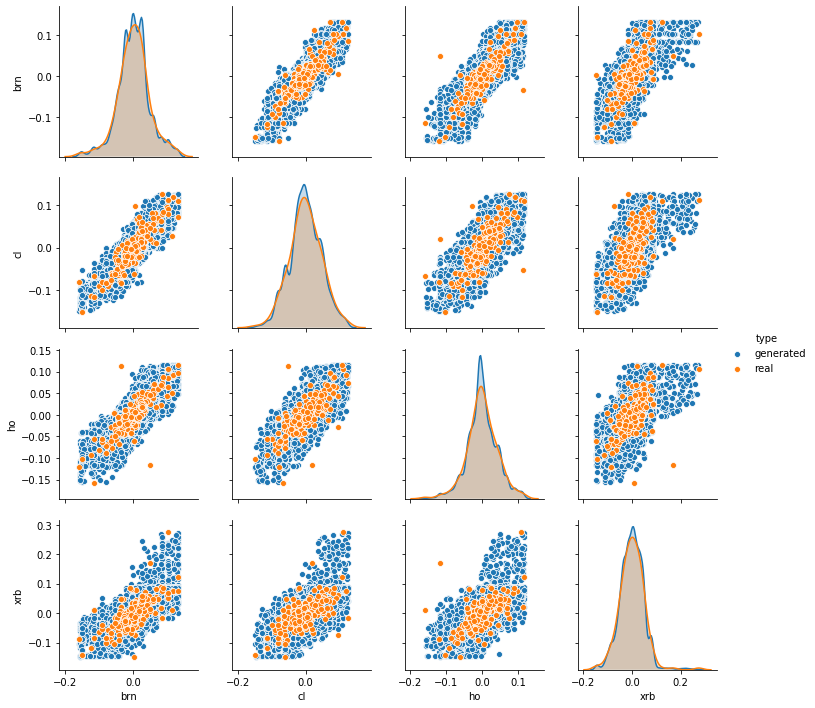

In [13]:
plot = sb.pairplot(pd.concat([gen_prices, prices]), hue="type")
plt.show()

In [14]:
gen_prices.corr()

,brn,cl,ho,xrb
brn,1.000000,0.879335,0.835171,0.704066
cl,0.879335,1.000000,0.766942,0.642709
ho,0.835171,0.766942,1.000000,0.602128
xrb,0.704066,0.642709,0.602128,1.000000


## Simple multivariate normal generation

In [15]:
mean = []
for i in ['brn', 'cl', 'ho', 'xrb']:
    mean.append(stats.norm.fit(prices[i])[0])
cov = np.array(prices.cov())    
norm_sample = np.random.multivariate_normal(mean, cov, size=10000)
gen_prices = pd.DataFrame(norm_sample, columns=['brn', 'cl', 'ho', 'xrb'])
gen_prices['type'] = 'generated'

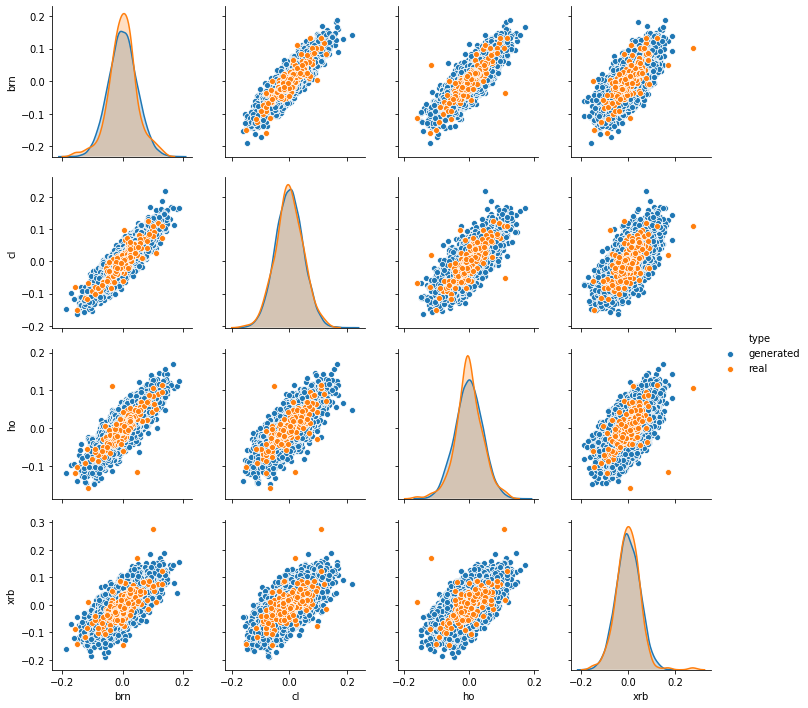

In [16]:
plot = sb.pairplot(pd.concat([gen_prices, prices]), hue="type")
plt.show()

## GAN Generation

In [20]:
tgan = TGANModel.load('gan_model.pkl')
gen_prices = tgan.sample(10000)
gen_prices['type'] = 'generated'

[0227 20:57:13 @collection.py:146] New collections created in tower : tf.GraphKeys.REGULARIZATION_LOSSES
[0227 20:57:13 @collection.py:165] These collections were modified but restored in : (tf.GraphKeys.SUMMARIES: 0->2)
[0227 20:57:13 @sessinit.py:87] WRN The following variables are in the checkpoint, but not found in the graph: global_step, optimize/beta1_power, optimize/beta2_power
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
[0227 20:57:14 @sessinit.py:114] Restoring checkpoint from output/model/model-50000 ...
INFO:tensorflow:Restoring parameters from output/model/model-50000


 24%|##4       |49/200[00:00<00:02,54.87it/s]


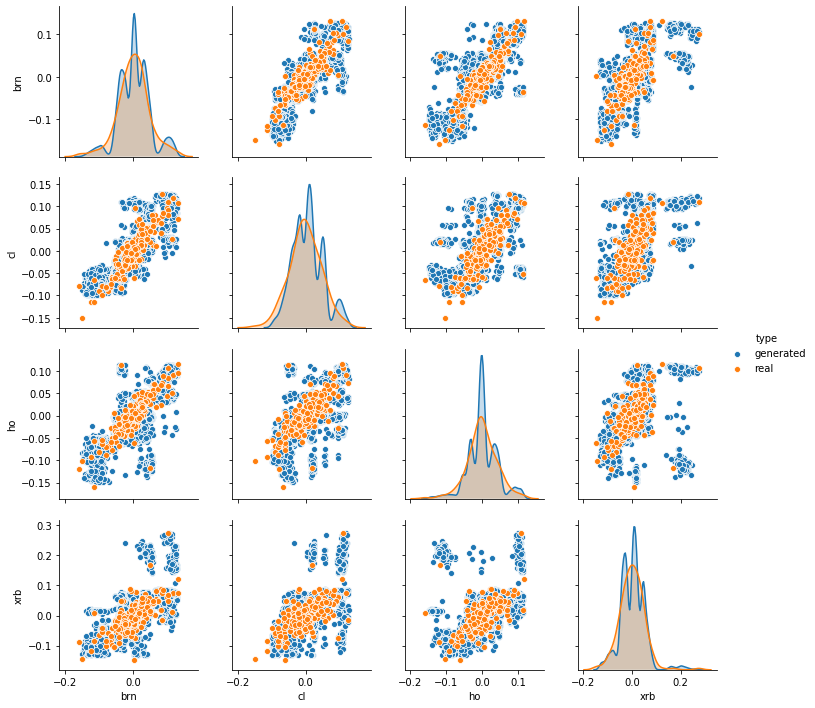

In [21]:
plot = sb.pairplot(pd.concat([gen_prices, prices]), hue="type")
plt.show()